# NLP Final Project Part V: Analysis of articles with Positive sentiment
•	Demonstrate what companies, academic institutions and government entities can do to improve the outcomes of data science initiatives (positive sentiment)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import requests
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import spacy 
from spacy import displacy

In [3]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_final_project_data/pos_text_custom.csv"
df= pd.read_csv(path,lineterminator='\n')

In [6]:
df.shape

(55462, 5)

In [7]:
# keep only letters, periods, and white space
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'[^a-zA-Z.\s]', '',x))
# remove stop words
stopwords = nltk.corpus.stopwords.words('english')
df["clean_text"] = df["clean_text"].apply(lambda x: ' '.join([word for word in x.split()if word not in (stopwords)]))

In [8]:
df.head(2)

,date,clean_title,clean_text,sentiment,sentiment_category
0,2017-02-07,SAP NS2’s Mark Testoni: AI Could Help Prevent ...,SAP NSs Mark Testoni AI Could Help Prevent Cyb...,1,Positive
1,2019-12-31,A Decade Of Advancements As We Enter A New Age...,A Decade Of Advancements As We Enter A New Age...,1,Positive


# Article Text Analysis
## Spacy
Positive sentiment data from custom logistic regression classifier

In [9]:
!python3 -m spacy download en_core_web_lg

2022-11-26 04:52:04.777986: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
entities = []
labels = []
position_start = []
position_end = []

for line in df["clean_text"]:
    doc = nlp(line)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    
df_spacy_custom = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

In [ ]:
df_spacy_custom.to_csv("spacy_positive_custom_classifier.csv", index = False)

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_model_output/spacy_positive_custom_classifier.csv"
df_spacy_custom= pd.read_csv(path,lineterminator='\n')

In [14]:
# exclude these words
Search_List =  ['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE']

In [5]:
# orgnization
org_df = df_spacy_custom[df_spacy_custom["Labels"]=="ORG"]
org_df["Entities"] = org_df["Entities"].apply(str)
org_df= org_df[~org_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_org_text = org_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# person
person_df = df_spacy_custom[df_spacy_custom["Labels"]=="PERSON"]
person_df["Entities"] = person_df["Entities"].apply(str)
person_df= person_df[~person_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_person_text = person_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# location
loc_df = df_spacy_custom[df_spacy_custom["Labels"]=="LOC"]
loc_df = loc_df[~loc_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_loc_text = loc_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

In [10]:
count_df_spacy_org_top_20 = count_df_spacy_org_text.sort_values(by = ['Labels'], ascending = False).head(19).rename(columns = {"Labels":"Count"})
count_df_spacy_org_top_20[["Count"]]

,Count
Entities,
Google,15559
Microsoft,8517
IBM,8349
Facebook,7863
Apple,5707
Amazon,5523
Intel,4056
Samsung,3565
Tesla,3287


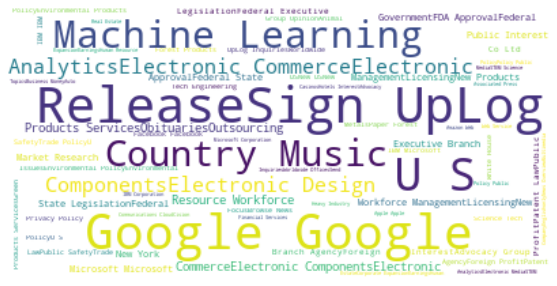

In [13]:
text = " ".join(entities for entities in org_df.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
count_df_spacy_person_top_20 = count_df_spacy_person_text.sort_values(by = ['Labels'], ascending = False).head(20).rename(columns = {"Labels":"Count"})
count_df_spacy_person_top_20[["Count"]]

,Count
Entities,
HardwareComputer,4192
Trump,2344
TransactionsResidential Real,2260
Elon Musk,1769
ReleaseSign,1647
UsContact,1618
Greta Van SusterenCircle Country Music LifestyleGray,1588
BusinessAwardsCommercial Real,1534
Kim Kardashian,1414


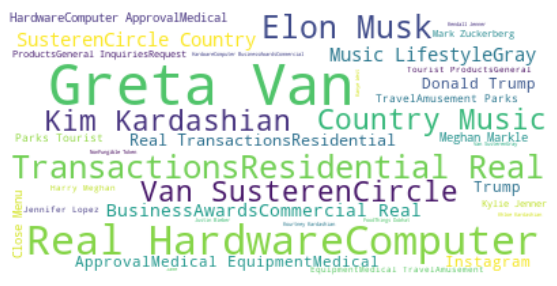

In [ ]:
text = " ".join(entities for entities in person_df.Entities.apply(str))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
count_df_spacy_loc_top_20 = count_df_spacy_loc_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_loc_top_20[["Labels"]]

,Labels
Entities,
Europe,2885
North America,2250
Silicon Valley,1501
Earth,1413
Asia,1385
NYC,1228
Latin America,879
Africa,784
Southeast Asia,618


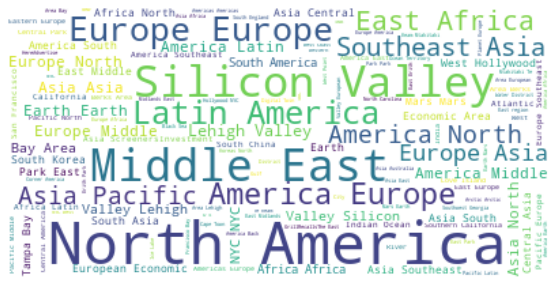

In [ ]:
text = " ".join(entities for entities in loc_df.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Article Title Analysis

In [10]:
nlp = spacy.load("en_core_web_lg")

In [11]:
entities = []
labels = []
position_start = []
position_end = []

for line in df["clean_title"]:
    doc = nlp(line)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    
df_spacy_custom_title = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

In [12]:
df_spacy_custom_title.to_csv("spacy_positive_custom_classifier_title.csv", index = False)

In [26]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_model_output/spacy_positive_custom_classifier.csv"
df_spacy_custom_title= pd.read_csv(path,lineterminator='\n')

In [15]:
# orgnization
org_df = df_spacy_custom_title[df_spacy_custom_title["Labels"]=="ORG"]
org_df["Entities"] = org_df["Entities"].apply(str)
org_df= org_df[~org_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_org_text = org_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# person
person_df = df_spacy_custom_title[df_spacy_custom_title["Labels"]=="PERSON"]
person_df["Entities"] = person_df["Entities"].apply(str)
person_df= person_df[~person_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_person_text = person_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# location
loc_df = df_spacy_custom_title[df_spacy_custom_title["Labels"]=="LOC"]
loc_df = loc_df[~loc_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_loc_text = loc_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

In [18]:
count_df_spacy_org_top_20 = count_df_spacy_org_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_org_top_20[["Labels"]]

,Labels
Entities,
Google,2502
IBM,2376
Microsoft,2169
Intel,1197
Courier,674
The Bisouv Network,597
TechRadar,569
Apple,554
Samsung,465


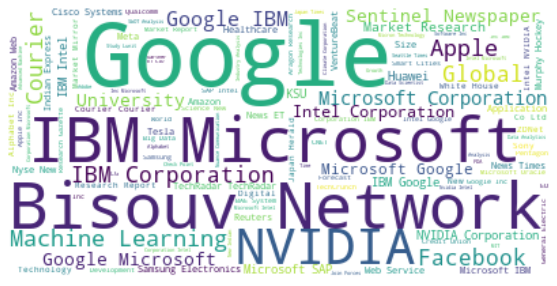

In [19]:
text = " ".join(entities for entities in org_df.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
count_df_spacy_person_top_20 = count_df_spacy_person_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_person_top_20[["Labels"]]

,Labels
Entities,
Murphy,201
Monroe Scoop,149
Elon Musk,131
CE Mark,98
Galus Australis,98
Mark Zuckerberg,87
Rembrandt,82
Beethoven,64
John Deere,57


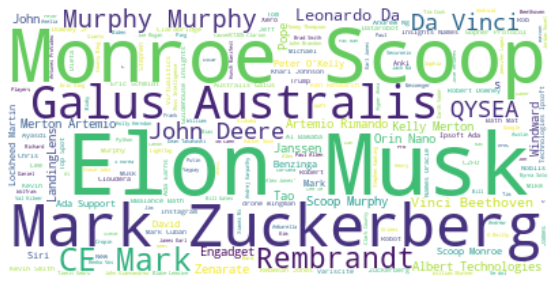

In [22]:
text = " ".join(entities for entities in person_df.Entities.apply(str))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
count_df_spacy_loc_top_20 = count_df_spacy_loc_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_loc_top_20[["Labels"]]

,Labels
Entities,
North America,302
NYC,76
Africa,73
Europe,70
Asia,66
Silicon Valley,59
Southeast Asia's,52
Earth,34
Middle East,31


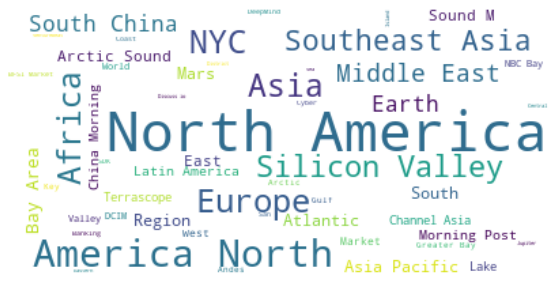

In [24]:
text = " ".join(entities for entities in loc_df.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()